<h1><center> Time Series Analysis </center></h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import statsmodels.graphics.tsaplots as tsa


"""
from scipy import stats
from statsmodels.tsa.arima_model import ARMA


import matplotlib.mlab as mlab


"""

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<h1><center> Données “Syndromes grippaux" </center></h1>

## Q1
Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/suivi-epidemiologique-temps-reel/ias-incidence-des-syndromes-grippaux pour plus
d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler
seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la
fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combien de données manquantes
comporte-t-elle ? Pour les traitements des questions suivantes, éliminez les données manquantes par
imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non-observées à partir
des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
df = pd.read_csv("OpenhealthS-Grippal.csv", delimiter=";", decimal=",", na_values=0)

In [3]:
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


La fréquence d'échantillonage est journalière, du 01-07-2009 au 17-04-2014

In [4]:
df['PERIODE'].min()

'2009-07-01'

In [5]:
df['PERIODE'].max()

'2014-04-17'

On vérifie qu'il y bien un record pour chaque jour, soit 1752 records

In [6]:
df['PERIODE'].count()

1752

In [7]:
delta = pd.to_datetime(df['PERIODE'].max()) - pd.to_datetime(df['PERIODE'].min())
print("nombre de jours de la période", delta.days + 1)

nombre de jours de la période 1752


On trouve 8 valeurs NaN

In [8]:
df['IAS_brut'].isnull().sum()

8

Pour remplacer les valeurs NaN on fait une interpolation linéaire

In [9]:
df['IAS_brut'] = df['IAS_brut'].interpolate()

## Q2
Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous
observez.

In [10]:
df['PERIODE'] = pd.to_datetime(df['PERIODE'])

Il semble qu'il y ait une certaine saisonalité, mais pas la période autour de 1 an n'est pas stable.

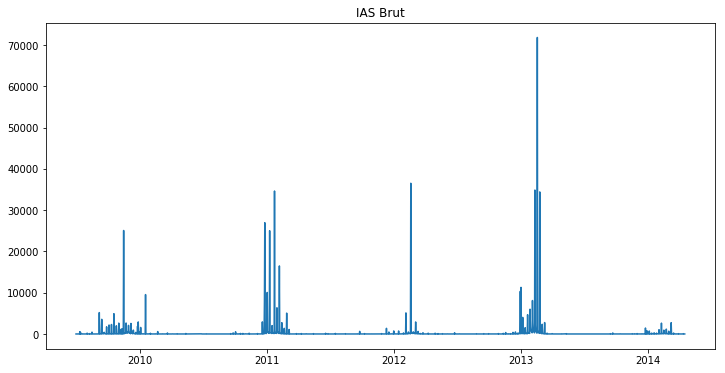

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df['PERIODE'], df['IAS_brut'])
plt.title("IAS Brut")
plt.show()

## Q3
Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme
a sur la trajectoire représentée à la question précédente ?

### Commentaire sur l'impact ???...

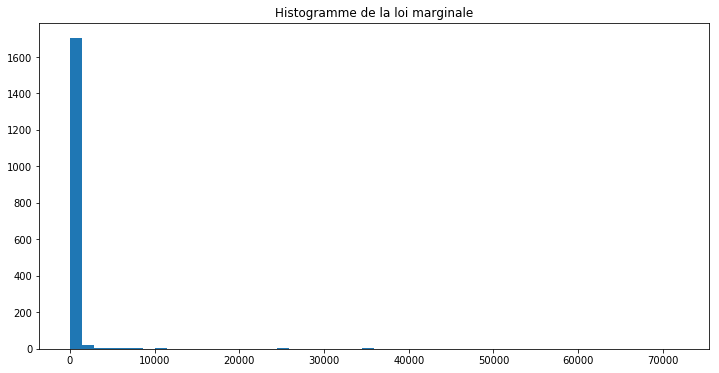

In [12]:
plt.figure(figsize=(12,6))
plt.hist(df['IAS_brut'], bins=50)
plt.title("Histogramme de la loi marginale")
plt.show()

## Q4
Reprenez les questions précédentes après tranformations des observations par le logarithme naturel.
Commentez.

### Commentaire???...

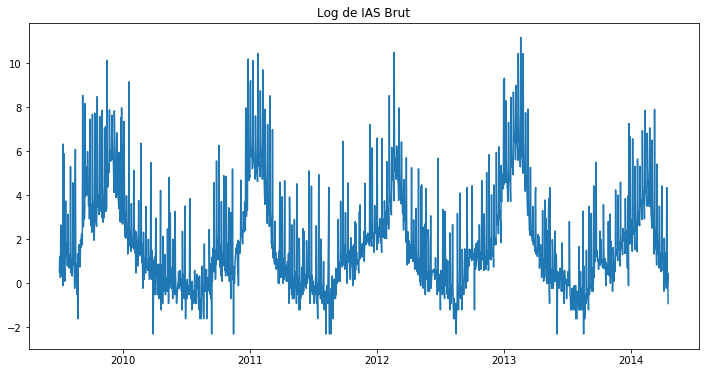

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df['PERIODE'],np.log(df['IAS_brut']))
plt.title("Log de IAS Brut")
plt.show()

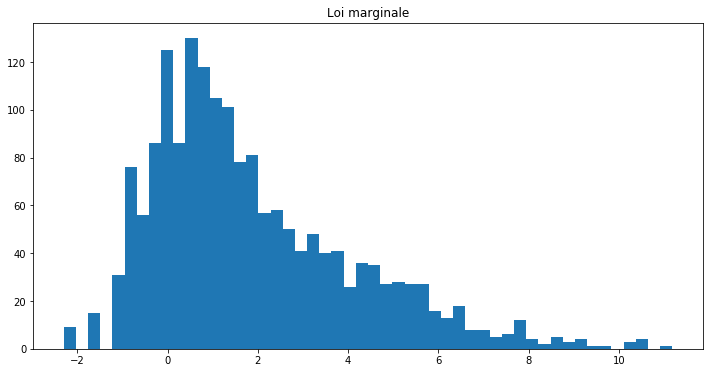

In [14]:
plt.figure(figsize=(12,6))
plt.hist(np.log(df['IAS_brut']), bins=50)
plt.title("Loi marginale")
plt.show()

## Q5
En utilisant signal.periodogram() (du package signal importé depuis scipy), tracez le périodogramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait
que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans
[−1/2, 1/2] plutôt que [−π, −π].

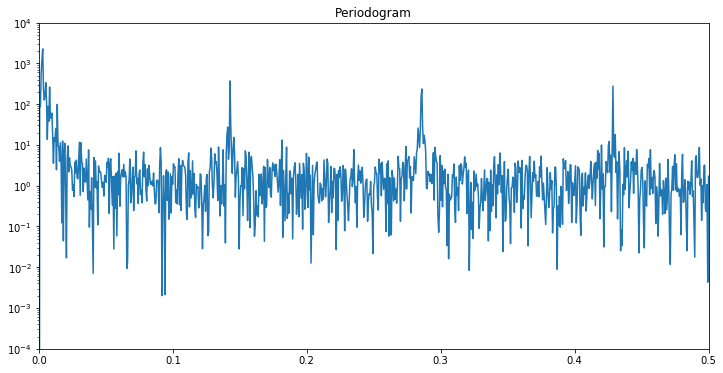

In [15]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']))
plt.semilogy(f, Pxx_den)
plt.title("Periodogram")
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

Les pics correspondent aux valeurs qui ne sont pas expliquées par le bruit de fond.

## Q6
Pour supprimer une tendance périodique de période T dans un signal (xt)t∈Z il suffit d’appliquer
le filtre ∆T défini par  
[∆T x]t = xt − x(t−T)  
Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

In [16]:
# on applique le filtre en considerant 1 an = 365 jours
time_diff = []
for i in range(365, len(df)) :
    time_diff.append(np.log(df.loc[i]['IAS_brut']) - np.log(df.loc[i-365]['IAS_brut']))

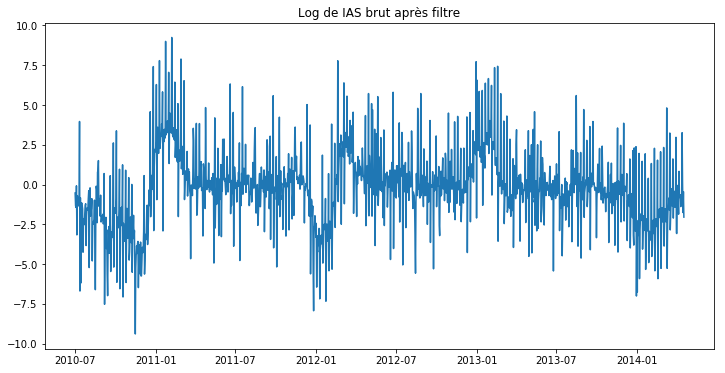

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df['PERIODE'][365:],time_diff)
plt.title("Log de IAS brut après filtre")
plt.show()

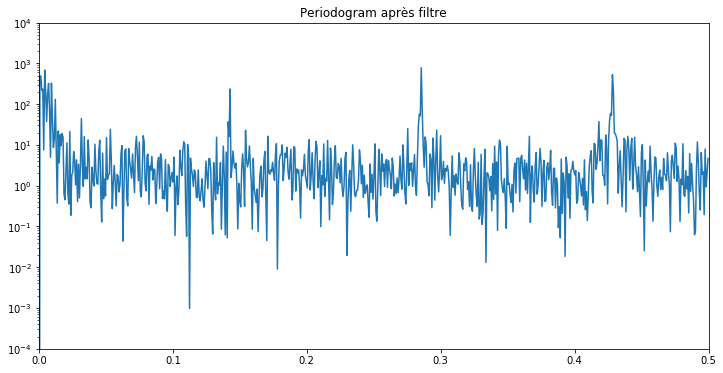

In [18]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(time_diff)
plt.semilogy(f, Pxx_den)
plt.title("Periodogram après filtre")
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

### Quelques pics ont disparu...

## Q7
On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va
prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant
sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance
périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez
les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez
deux variables explicatives, xi,2k−1 = cos(ti
· k ·
2π / T
) et xi,2k = sin(ti
· k ·
2π / T
), où ti est le moment
de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. 

In [19]:
n_harm = 10

In [20]:
X = df.copy()
# on peut utiliser les nombres entiers au lieu de dates
X['index'] = X.index

In [21]:
X.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,index
0,2009-07-01,1.7,2.2,2.3,0
1,2009-07-02,3.4,2.1,2.3,1
2,2009-07-03,2.1,2.1,2.3,2
3,2009-07-04,1.3,2.0,2.3,3
4,2009-07-05,14.2,2.0,2.3,4


In [22]:
for k in range(1, n_harm+1) :
    X['add_cos' + str(k)] = np.cos(X['index'] * k * 2 * math.pi / 365)
    X['add_sin' + str(k)] = np.sin(X['index'] * k * 2 * math.pi / 365)

In [23]:
X_train = X[X['PERIODE'] < "2013-03-31"].drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)
X_test = X[X['PERIODE'] >= "2013-03-31"].drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)

In [24]:
X_train.head()

,PERIODE,IAS_brut,index,add_cos1,add_sin1,add_cos2,add_sin2,add_cos3,add_sin3,add_cos4,...,add_cos6,add_sin6,add_cos7,add_sin7,add_cos8,add_sin8,add_cos9,add_sin9,add_cos10,add_sin10
0,2009-07-01,1.7,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,2009-07-02,3.4,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,...,0.994671,0.103102,0.992749,0.120208,0.990532,0.137279,0.988023,0.154309,0.985220,0.171293
2,2009-07-03,2.1,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,...,0.978740,0.205104,0.971100,0.238673,0.962309,0.271958,0.952378,0.304921,0.941317,0.337523
3,2009-07-04,1.3,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,...,0.952378,0.304921,0.935368,0.353676,0.915864,0.401488,0.893919,0.448229,0.869589,0.493776
4,2009-07-05,14.2,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,...,0.915864,0.401488,0.886071,0.463550,0.852078,0.523416,0.814046,0.580800,0.772157,0.635432


#### Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives.

In [25]:
y_train = X_train['IAS_brut']
X_train = X_train.drop(['IAS_brut', 'PERIODE'], axis=1)

In [26]:
est = sm.OLS(y_train, X_train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               IAS_brut   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.135
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           1.28e-09
Time:                        16:31:11   Log-Likelihood:                -12916.
No. Observations:                1369   AIC:                         2.587e+04
Df Residuals:                    1348   BIC:                         2.598e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4655      0.105      4.418      0.0

#### Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013 au 17 avril 2014.

In [27]:
y_test = X_test['IAS_brut']
X_test = X_test.drop(['PERIODE', 'IAS_brut'], axis = 1)
pred = est.predict(X_test)
pred.head()

1369    410.634708
1370    422.594665
1371    429.162458
1372    430.459966
1373    426.757923
dtype: float64

#### Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utilisez les couleurs différentes pour pour les partie apprentissage et prédiction).

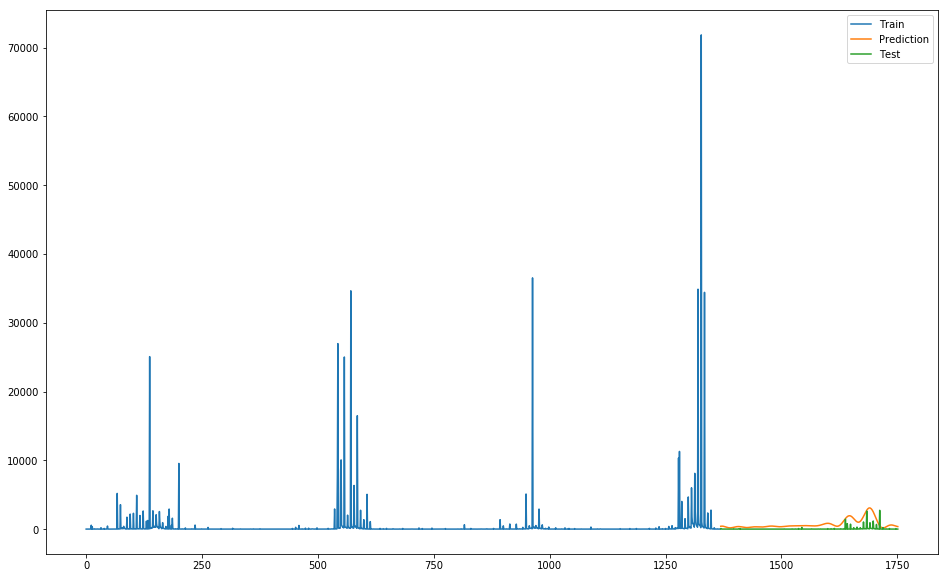

In [28]:
plt.figure(figsize=(16,10))
plt.plot(y_train, label="Train")
plt.plot(pred, label="Prediction")
plt.plot(y_test, label="Test")
plt.legend()
plt.show()

#### Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.

In [29]:
quad_risk = sum((y_test - pred)**2)
quad_risk / len(pred)

831551.2836502824

In [30]:
residus = y_test - pred

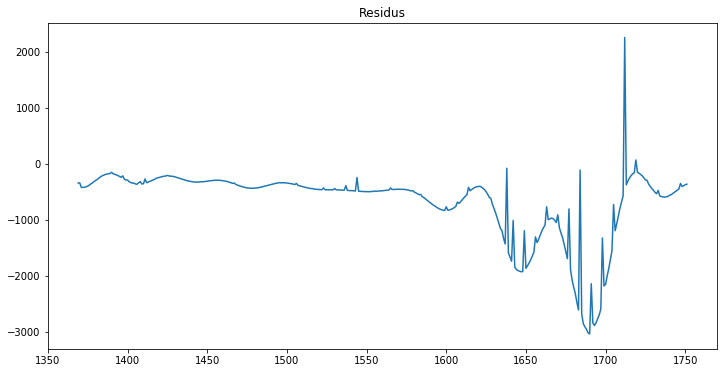

In [31]:
plt.figure(figsize=(12,6))
plt.plot(residus)
plt.title("Residus")
plt.show()

Plus n_harm est élevé, plus la forme de la prédiction sera complexe. Il y a un optimum vers 5.

<h1><center> Données “Trafic internet” </center></h1>

## Q8
Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet et la première variable et le moment de sa transmission ; consultez http://ita.ee.lbl.gov/html/contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du jeu de données.

"The first script was used to produce lbl-tcp-3.tcp, which has six columns: timestamp, (renumbered) source host, (renumbered) destination host, source TCP port, destination TCP port, and number of data bytes (zero for "pure-ack" packets)"

In [32]:
col_names = ["timestamp", "sourceHost", "destinationHost", "sourceTCPPort", "destinationTCPPort", "bytes"]

In [33]:
df = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names = col_names, header=None)

In [34]:
df.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets
transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720
observations. Tracez la série temporelle obtenue

"The trace ran from 14:10 to 16:10 on Thursday, January 20, 1994 (times are Pacific Standard Time), capturing 1.8 million TCP packets (about 0.0002 of these were dropped). The tracing was done on the Ethernet DMZ network over which flows all traffic into or out of the Lawrence Berkeley Laboratory, located in Berkeley, California. The raw trace was made using tcpdump on a Sun Sparcstation using the BPF kernel packet filter. Timestamps have microsecond precision."

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789995 entries, 0 to 1789994
Data columns (total 6 columns):
timestamp             float64
sourceHost            int64
destinationHost       int64
sourceTCPPort         int64
destinationTCPPort    int64
bytes                 int64
dtypes: float64(1), int64(5)
memory usage: 81.9 MB


In [36]:
df.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [37]:
df.loc[0, 'timestamp']

759103800.0081849

In [38]:
# on sait que les timestamp couvrent une plage de 2h * 3600 s = 7200 s
# on retire la première ligne qui sert de referent
(df['timestamp'][1:].max() - df['timestamp'].min()) / 7200 
# = 1 donc le timestamp represente le nombre de secondes ecoulee depuis le premier paquet

0.9999985294444443

In [39]:
# on met a 0 le top de debut
df.loc[0, 'timestamp'] = 0
df['chrono'] = ((df['timestamp']*1000000) // 10000000).astype(int)

In [40]:
df.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes,chrono
0,0.000000,1,2,23,2436,1,0
1,0.010445,2,1,2436,23,2,0
2,0.023775,1,2,23,2436,2,0
3,0.026558,2,1,2436,23,1,0
4,0.029002,3,4,3930,119,42,0


In [41]:
df = df.groupby(['chrono']).size().reset_index(name='nb_paquet')

In [42]:
df.head()

,chrono,nb_paquet
0,0,1615
1,1,1729
2,2,3220
3,3,1767
4,4,1891


In [43]:
# on vérifie
df['nb_paquet'].sum()

1789995

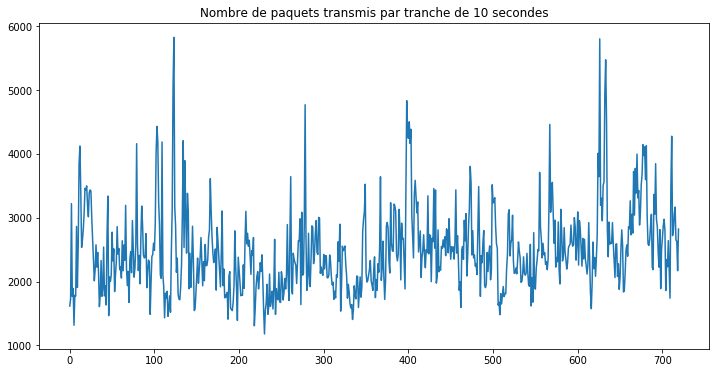

In [44]:
plt.figure(figsize=(12,6))
plt.plot(df['nb_paquet'])
plt.title("Nombre de paquets transmis par tranche de 10 secondes")
plt.show()

## Q9
Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage
du modèle ne demande pas beaucoup de temps et s’effectue avec 1 − 2 ligne de code à l’aide
de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p
(d’une gamme de valeur prédéfinies, disons de 1 à pmax) est moins simple. On va aborder trois
possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation
croisée/backtesting.

Le critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés
directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la
coupe en nchunks chunks/folds et chaque fois utilise k premiers chunks pour entrainer le modèle et
le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique). Pour une gamme de valeur choisie, effectue les trois méthodes de la sélection du modèle.

In [45]:
 s=pd.Series(df['nb_paquet'])

In [56]:
aic = []
bic = []
for p in range(1,10):
    arima = ARIMA(s, order=(p,0,0))
    arima = arima.fit()
    aic.append(arima.aic)
    bic.append(arima.bic)

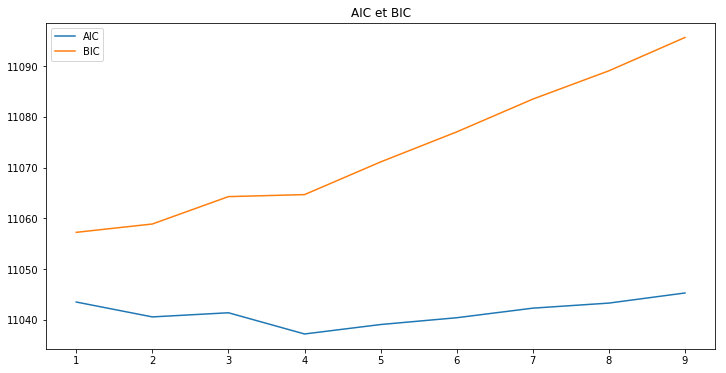

In [69]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10),aic, label="AIC")
plt.plot(range(1,10), bic, label="BIC")
#plt.plot(range(1,10), mse, label="validation croisée")
plt.legend()
plt.title("AIC et BIC")
plt.show()

On obtient un minimum du aic pour p=4, et un minimum du bic dès p=1

In [66]:
n_chunks = 5
longueur = len(s)
l_chunks = int(longueur / n_chunks)
mse = []

for p in range(1,10):
    k = 0
    mse_t = []

    for i in range(1,n_chunks) :
        k = k + l_chunks
        train = s.loc[:k-1]
        test = s.loc[k:k + l_chunks-1]
        arima = ARIMA(train, order=(p,0,0))
        arima = arima.fit()
        pred = arima.predict(start=k, end=k+l_chunks-1)
        mse_t.append(mean_squared_error(pred, test))
    mse.append(np.mean(mse_t))

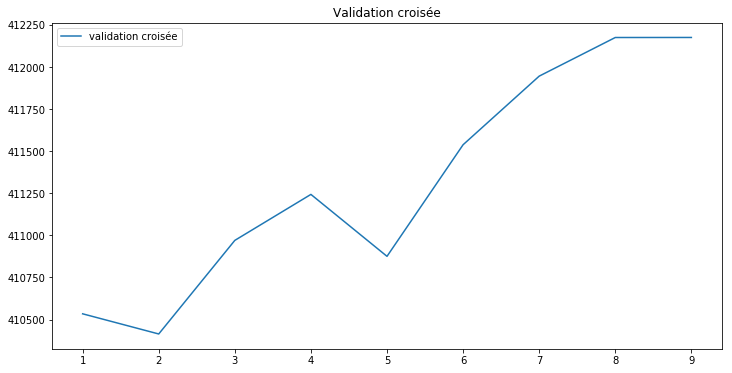

In [70]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10), mse, label="validation croisée")
plt.legend()
plt.title("Validation croisée")
plt.show()

On obtient un minimum pour p=2

10. En se basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à
estimer et affichez les paramètres correspondants.  
Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement.
Commentez.

p=2 optimise globalement les 3 indicateurs aic, bic et mse...

In [71]:
p=2
arima = ARIMA(s, order=(p,0,0))
arima = arima.fit()
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:              nb_paquet   No. Observations:                  720
Model:                     ARMA(2, 0)   Log Likelihood               -5516.273
Method:                       css-mle   S.D. of innovations            513.996
Date:                Wed, 22 Jan 2020   AIC                          11040.546
Time:                        16:46:41   BIC                          11058.863
Sample:                             0   HQIC                         11047.617
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2484.3516     53.679     46.282      0.000    2379.144    2589.560
ar.L1.nb_paquet     0.5614      0.037     15.115      0.000       0.489       0.634
ar.L2.nb_paquet     0.0827      

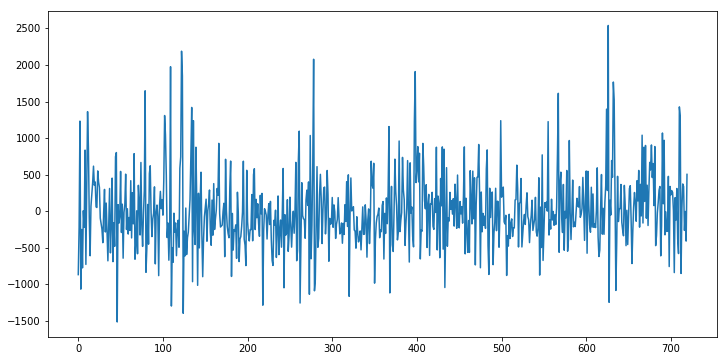

In [79]:
plt.figure(figsize=(12,6))
residus = arima.resid
residus.plot()
plt.show()

In [73]:
mean = residus.mean()
std = residus.std()
print("Moyenne = {} , écart-type = {}".format(mean,std))

Moyenne = 0.9506436863830439 , écart-type = 514.7402917676574


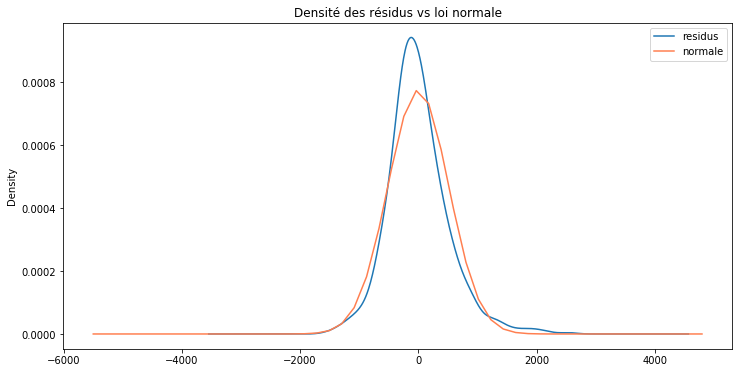

In [80]:
plt.figure(figsize=(12,6))
residus.plot(kind='kde', label='residus')
x = np.linspace(-5500, 4800)
y = norm.pdf(x,mean,std)
plt.plot(x,y, color='coral', label='normale')
plt.title("Densité des résidus vs loi normale")
plt.legend(loc='upper right');
plt.show()

Les résidus s'approchent d'une distribution normale.

<h1><center> Données “Southern Oscillation Index” </center></h1>

## Q11
Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [75]:
df = pd.read_csv("soi.tsv", delimiter="\t", header=None).T
df.head()

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


In [76]:
print("nombre de valeurs : ",len(df))
print("nombre de valeurs NaN : ",df.isna().sum().sum())

nombre de valeurs :  781
nombre de valeurs NaN :  1


In [77]:
df = df.dropna()

In [78]:
len(df)

780

## Q12
A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots,
tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

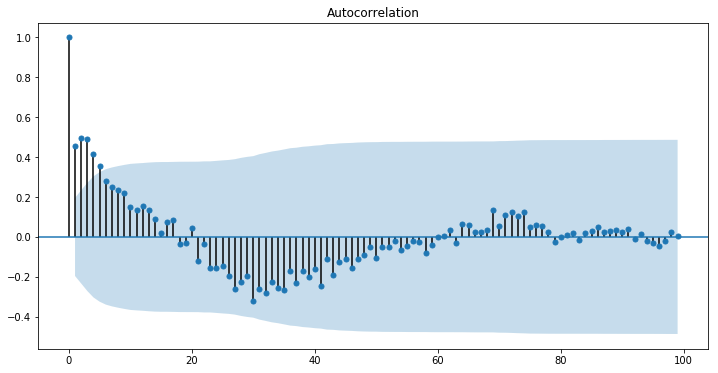

In [110]:
fig=plt.figure(figsize=(12,6))
ax = plt.axes()
tsa.plot_acf(df[:100],ax=ax)
plt.show()

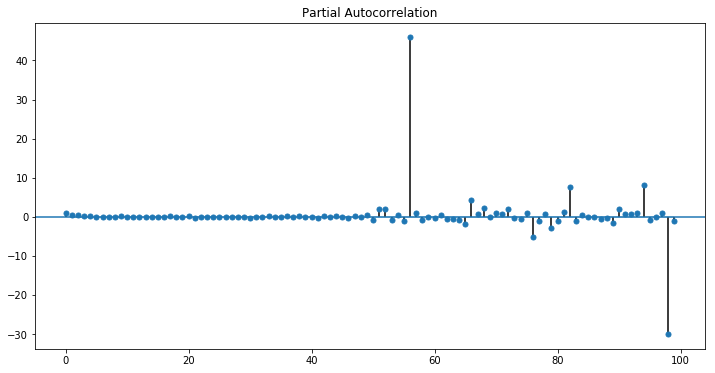

In [112]:
fig=plt.figure(figsize=(12,6))
ax = plt.axes()
tsa.plot_pacf(df[:100], ax=ax)
plt.show()

## Q13
En se basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p).
Entrainer le modèle AR choisi.

L'autorrelation est significative jusqu'à environ un ordre de 4. 

In [84]:
p = 4
arima = ARIMA(df, order=(p,0,0))
arima = arima.fit()

In [85]:
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                  780
Model:                     ARMA(4, 0)   Log Likelihood                -821.290
Method:                       css-mle   S.D. of innovations              0.693
Date:                Wed, 22 Jan 2020   AIC                           1654.579
Time:                        16:51:05   BIC                           1682.535
Sample:                             0   HQIC                          1665.331
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      0.106      1.214      0.225      -0.079       0.337
ar.L1.0        0.4226      0.036     11.793      0.000       0.352       0.493
ar.L2.0        0.2530      0.039      6.531      0.0

Tracez les résidus. Tracez l’estimation de la densité de résidus et la
densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et
comparez les visuellement. Commentez.

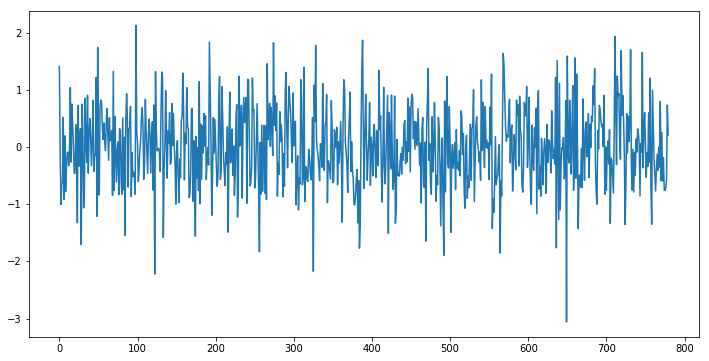

In [86]:
plt.figure(figsize=(12,6))
residus = arima.resid
residus.plot()
plt.show()

In [87]:
mean = residus.mean()
std = residus.std()
print("Moyenne = {} , écart-type = {}".format(mean,std))

Moyenne = -0.00219844293290489 , écart-type = 0.6944775737609069


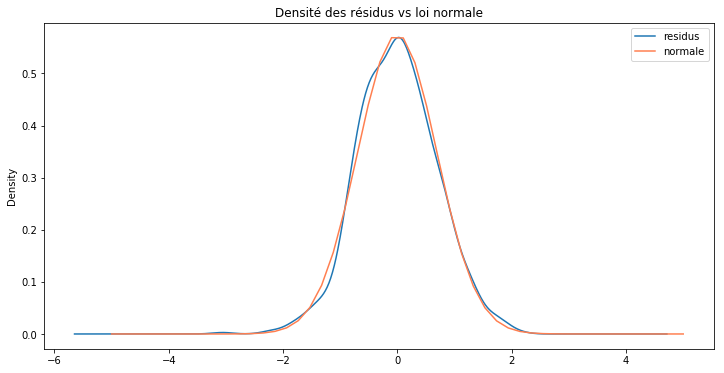

In [113]:
plt.figure(figsize=(12,6))
residus.plot(kind='kde', label='residus')
x = np.linspace(-5, 5)
y = norm.pdf(x,mean,std)
plt.plot(x,y, color='coral', label='normale')
plt.title("Densité des résidus vs loi normale")
plt.legend(loc='upper right')
plt.show()

Les résidus suivent parfaitement une distribution normale.

## Q14
Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question
précédente. On utilisera qu’un modèle AR(p) de coefficients auto-régressifs φ1, . . . , φp satisfaisant
l’équation AR

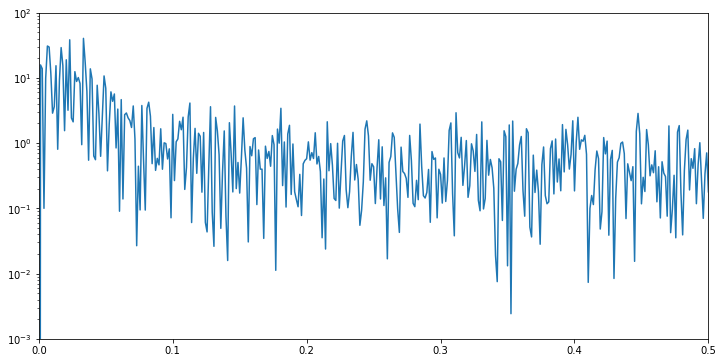

In [89]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(df[0])
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-3, 1e+2])
plt.show()